In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun
from scipy.interpolate import interp1d
import datetime
from matplotlib import patches

import matplotlib
matplotlib.rc('font',**{'family':'serif'})

In [2]:

#### load up the IceCube events
icecat = np.genfromtxt("IceCube_Gold_Bronze_Tracks_copy.csv", delimiter=",", skip_header=1, names=["type", "ra", "dec"])

[14.742 14.79  14.839 14.909 14.987 15.087 15.204 15.345 15.5   15.654
 15.744 15.765 15.77  15.822 16.021 16.219 16.416 16.613 16.811 17.008
 17.206 17.403 17.601 17.798 17.996 18.194 18.392 18.59  18.787 18.985
 19.184 19.382 19.58  19.778 19.921]


/var/folders/3m/5_pf65y17893_pm3xqy9kcv40000gn/T/ipykernel_64035/262647539.py:155: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


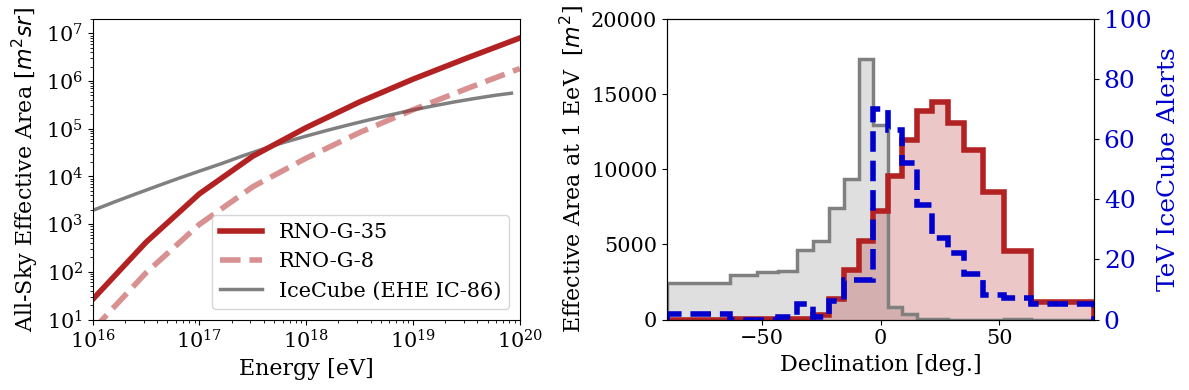

In [8]:


# instantiate figure

fig, (ax2,ax) = plt.subplots(1, 2, figsize=(12,4),gridspec_kw={'width_ratios': [1, 1]})


# absolute effective volume
######################################
######################################
######################################

cross_section_E = np.log10(np.asarray([1e4,2.5e4,6e4,1e5,2.5e5,6e5,1e6,2.5e6,6e6,1e7,2.5e7,6e7,1e8,2.5e8,6e8,1e9,2.5e9,6e9,1e10,2.5e10,6e10,1e11,2.5e11,6e11,1e12]))+9.0#eV
cross_sections = np.asarray([0.63e-34,0.12e-33,0.22e-33,0.3e-33,0.49e-33,0.77e-33,0.98e-33,0.15e-32,0.22e-32,0.27e-32,0.4e-32,0.56e-32,0.67e-32,0.94e-32,0.13e-31,0.15e-31,0.2e-31,0.27e-31,0.31e-31,0.41e-31,0.53e-31,0.61e-31,0.8e-31,0.1e-30,0.12e-30])#cm
from scipy.interpolate import interp1d
xsec_interpolator = interp1d(cross_section_E, cross_sections) # in cm^2
rho_factor=917.0/1000.00 #g/cm^3
m_n = 1.67e-24 #g


# ARA (starts with km3 sr)
Energy_EV = np.asarray([16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0])
ARA_veff = np.array([1.105E-1, 5.195E-1, 1.826E+0, 5.259E+0,1.106E+1, 2.077E+1, 3.431E+1, 5.073E+1])
PA_veff = np.array([2.618E-1, 1.003E+0, 3.096E+0, 7.406E+0,1.466E+1, 2.578E+1, 4.039E+1, 5.073E+1])

total_ARA_veff = (ARA_veff*4)+PA_veff
total_ARA_veff = total_ARA_veff*1E9 # m3 sr
L_int_ARA = m_n/(rho_factor * xsec_interpolator(Energy_EV))/100 # cm to m
total_ARA_aeff = total_ARA_veff/L_int_ARA # m2 sr

# RNOG (starts with km3)
RNOG_data = np.loadtxt('RNOG_effV.txt',delimiter=',',skiprows=1)
RNOG_energy = RNOG_data[:,0]
RNOG_veff = RNOG_data[:,1]*4*np.pi # km3 sr

RNOG_veff = RNOG_veff*1E9 # m3 sr
L_int_RNOG = m_n/(rho_factor * xsec_interpolator(RNOG_energy))/100 # cm to m
RNOG_aeff = RNOG_veff/L_int_RNOG # m2 sr


# IceCube (starts with m2 sr)
IC_data = np.loadtxt('IceCube_Aeff.csv',delimiter=',',skiprows=1)
IC_aeff = np.asarray(IC_data[:,1])
IC_energy = np.log10(np.asarray(IC_data[:,0]))+9

colors=['black','grey','firebrick']

# line_ARA, =ax2.plot(10**Energy_EV,total_ARA_aeff,color=colors[0],lw=2.5,label='ARA (5 Stations)')
line_IC, = ax2.plot(10**IC_energy,IC_aeff,lw=2.5,color=colors[1],label='IceCube (EHE IC-86)')
line_RNOG, =ax2.plot(10**RNOG_energy,RNOG_aeff,lw=4,color=colors[2],label='RNO-G-35')
line_RNOG_8, =ax2.plot(10**RNOG_energy,RNOG_aeff/35*8,lw=4,color=colors[2],label='RNO-G-8', alpha=0.5, ls='--')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim([1e16,1e20])
ax2.set_ylim([1e1,2e7])
ax2.legend(handles=[line_RNOG,
                    line_RNOG_8,
                    line_IC,
                    # ,line_ARA
                    ],
                    loc='lower right',fontsize=15)
ax2.set_xlabel('Energy [eV]')
ax2.set_ylabel('All-Sky Effective Area [$m^2 sr$]')
# ax2.grid()

def find_nearest_energy_bin(array, value):
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]
# ara_bin, ara_en = find_nearest_energy_bin(10**Energy_EV, 1e18)
rnog_bin, rnog_en = find_nearest_energy_bin(10**RNOG_energy, 1e18)
ic_bin, ic_en = find_nearest_energy_bin(10**IC_energy, 1E18)

print(IC_energy)
# ara_at_1EeV = total_ARA_aeff[ara_bin]
rnog_at_1EeV = RNOG_aeff[rnog_bin]
ic_at_1EeV = IC_aeff[ic_bin]
# print(f"ARA {ara_at_1EeV:e}, RNOG {rnog_at_1EeV:e}, IC {ic_at_1EeV:e}")


# relative effective area plot
######################################
######################################
######################################

import json

def get_bin_centers(bins):
    return (bins[1:] + bins[:-1]) * 0.5

# IceCube
IC = open('rel_areas_ic.json')
IC_data = json.load(IC)
IC_dec_bin_edges = np.asarray(IC_data['dec_bin_edges'])
IC_dec_bin_centers = get_bin_centers(IC_dec_bin_edges)
IC_rel_eff_areas = np.asarray(IC_data['relative_eff_areas'])
IC_abs_eff_areas = IC_rel_eff_areas * ic_at_1EeV
ax.hist(
    IC_dec_bin_centers, bins=IC_dec_bin_edges, weights=IC_abs_eff_areas,
    histtype='step', color='grey', lw=2.5
)
ax.hist(
    IC_dec_bin_centers, bins=IC_dec_bin_edges,
    weights=IC_abs_eff_areas, color='grey', alpha=0.25
)

# RNO-G
RNOG = open('rel_areas_gl.json')
RNOG_data = json.load(RNOG)
RNOG_dec_bin_edges = np.asarray(RNOG_data['dec_bin_edges'])
RNOG_dec_bin_centers = get_bin_centers(RNOG_dec_bin_edges)
RNOG_rel_eff_areas = np.asarray(RNOG_data['relative_eff_areas'])
RNOG_abs_eff_areas = RNOG_rel_eff_areas * rnog_at_1EeV
ax.hist(
    RNOG_dec_bin_centers, bins=RNOG_dec_bin_edges, weights=RNOG_abs_eff_areas,
    histtype='step', color='firebrick', lw=4
)
ax.hist(
    RNOG_dec_bin_centers, bins=RNOG_dec_bin_edges,
    weights=RNOG_abs_eff_areas, color='firebrick', alpha=.25
)

# ax.hist(
#     RNOG_dec_bin_centers, bins=RNOG_dec_bin_edges, weights=RNOG_abs_eff_areas/35*8,
#     histtype='step', color='black', lw=4
# )
# ax.hist(
#     RNOG_dec_bin_centers, bins=RNOG_dec_bin_edges,
#     weights=RNOG_abs_eff_areas/35*8, color='black', alpha=.25
# )

ax_icecat = ax.twinx()  # instantiate a second Axes that shares the same x-axis

ax_icecat.hist(icecat["dec"], bins=RNOG_dec_bin_edges, 
        weights=np.ones_like(icecat["dec"]), histtype="step",
        lw=4, color="mediumblue", ls="--"
        )
ax_icecat.set_ylabel("TeV IceCube Alerts", size=18, color="mediumblue")
ax_icecat.tick_params(axis="y", labelsize=18, labelcolor="mediumblue")
ax_icecat.set_ylim([0,100])


# make axes pretty
# ax.grid()
ax.set_xlabel('Declination [deg.]',fontsize=20)
ax.set_ylabel("Effective Area at 1 EeV  [$m^2$]")
ax.set_xlim([-90,90])
ax.set_ylim([0,20000])

for a in [ax, ax2]:
    a.yaxis.label.set_fontsize(16)
    a.xaxis.label.set_fontsize(16)
    a.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
fig.show()
plt.savefig('combo_veffvsen_veffvsdec.pdf',bbox_inches='tight', dpi=300)
plt.savefig('combo_veffvsen_veffvsdec.png',bbox_inches='tight', dpi=300)


